# Fake News Detection on Social Media



## Introduction

In today's world, we see people post and publish any content on the internet, and one of them is writing article news. As smartphone users, we use our smartphones to read the news since everything is online. However, there's a ton of fake news floating around on the internet, where misinformation can manipulate public opinion, impact election results, and create social chaos. It's really hard to tell what's real and what's not. This can mess with people's opinions and the choices they make.

In this project, we will focus on the challenge of identifying fake news using machine learning techniques. We developed a system that analyzes news articles to classify them as real or fake. We worked with two different ways to do this: one’s called Logistic Regression, Transformers Model and the other’s Random Forest Classifier. This shows that using machine learning can help in catching fake news. Our project is a step towards making sure the news is what it says it is and helps people understand that not everything you read online is true.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EvalPrediction
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



# Dataset

We found this dataset from Kaggle, which consists an individual news articles collected from various sources. You can find it in this link:
[here](https://www.kaggle.com/datasets/algord/fake-news)

According to Kaggle, this data was cleaned and combined in one file and some columns were changed. The original data was obtained from someone in Git Hub [here](https://github.com/KaiDMML/FakeNewsNet). The GitHub page for FakeNewsNet is a resource for those seeking to detect fake news. It contains data from both real and fake news stories, sourced from PolitiFact and GossipCop.

The dataset contains 23,196 rows of information about news articles. This dataset is composed of 5 columns that offer a diverse range of information about each article.

Format: CSV.

*   title: title of the article.
*   news_url: URL of the article.
*   source domain: web domain where article was posted.
*   tweet_num: number of retweets for this article.
*   real: label column, where 1 is real and 0 is fake.


# 1. Data processing

In [ ]:
data = pd.read_csv('FakeNewsNet.csv')

data.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [ ]:
data.describe()

,tweet_num,real
count,23196.000000,23196.000000
mean,88.956803,0.751897
std,488.694592,0.431921
min,0.000000,0.000000
25%,11.000000,1.000000
50%,37.000000,1.000000
75%,65.000000,1.000000
max,29060.000000,1.000000


In [ ]:
data.shape

(23196, 5)

In [ ]:
data.columns

Index(['title', 'news_url', 'source_domain', 'tweet_num', 'real'], dtype='object')

In [ ]:
data["source_domain"].unique()

array(['toofab.com', 'www.today.com', 'www.etonline.com', ...,
       'www.aft.org', 'www.thaivisa.com', 'flashnewscorner.com'],
      dtype=object)

In [ ]:
source_count = data["source_domain"].value_counts()
source_count.head(10)

source_domain
people.com                   1786
www.dailymail.co.uk           964
en.wikipedia.org              741
www.usmagazine.com            709
www.etonline.com              666
www.longroom.com              549
hollywoodlife.com             524
www.usatoday.com              332
www.hollywoodreporter.com     330
variety.com                   304
Name: count, dtype: int64

In [ ]:
real_counts = data["real"].value_counts()
real_counts

real
1    17441
0     5755
Name: count, dtype: int64

## 1.2 Missing data

In [ ]:
missing_values = data.isnull().sum()
missing_values

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [ ]:
mssing_percentage = (missing_values / len(data)) * 100

print("Missing Values in each column:\n", mssing_percentage)

Missing Values in each column:
 title            0.000000
news_url         1.422659
source_domain    1.422659
tweet_num        0.000000
real             0.000000
dtype: float64


In [ ]:
data_cleaned = data.dropna()

print("\nMissing values in each column after removal:")
print(data_cleaned.isnull().sum())


Missing values in each column after removal:
title            0
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64


# 2. Data Analysis

This chart shows the count of real vs. fake news articles in the dataset. It provides a clear view of the class binary distribution, which is crucial for understanding the balance in your dataset.

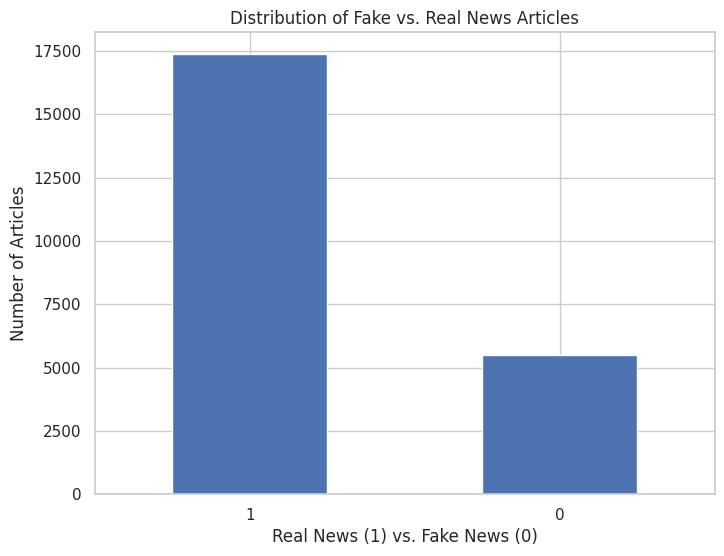

In [ ]:
real_fake_distribution = data_cleaned['real'].value_counts()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
real_fake_distribution.plot(kind='bar')
plt.title('Distribution of Fake vs. Real News Articles')
plt.xlabel('Real News (1) vs. Fake News (0)')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

Top 10 Sources for Real News



<ipython-input-14-e3770edee736>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=real_news_sources.values, y=real_news_sources.index, palette='Blues_d')


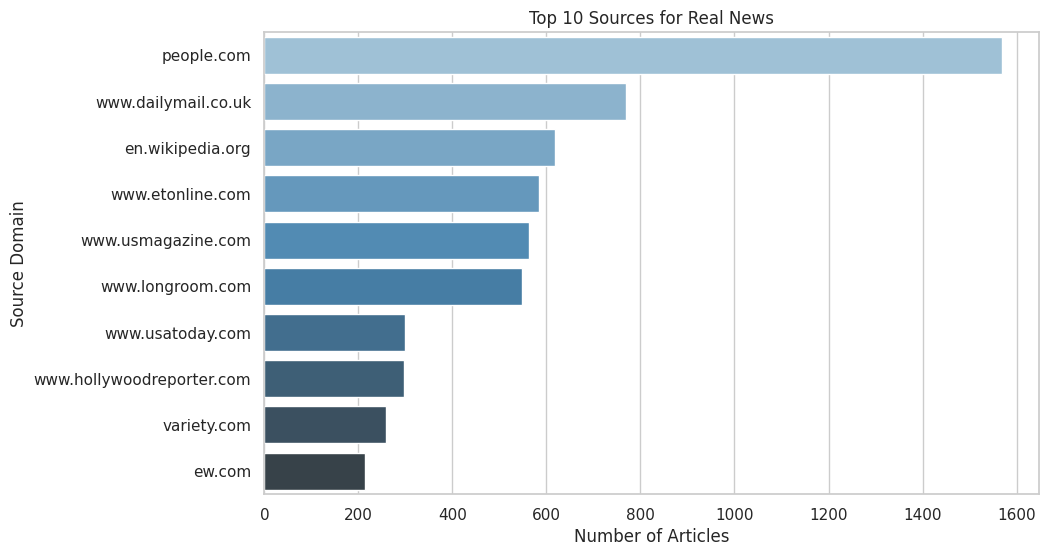

In [ ]:
real_news_sources = data_cleaned[data_cleaned['real'] == 1]['source_domain'].value_counts().head(10)


plt.figure(figsize=(10, 6))
sns.barplot(x=real_news_sources.values, y=real_news_sources.index, palette='Blues_d')
plt.title('Top 10 Sources for Real News')
plt.xlabel('Number of Articles')
plt.ylabel('Source Domain')
plt.show()


Top 10 Sources for Fake News


<ipython-input-15-eded4a210c9b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=real_news_sources.values, y=real_news_sources.index, palette='Reds_d')


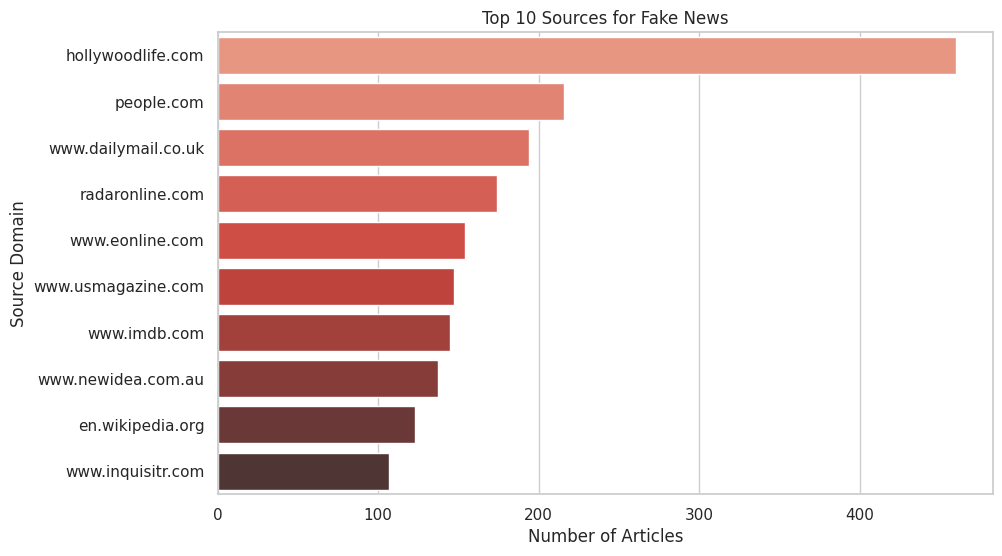

In [ ]:
real_news_sources = data_cleaned[data_cleaned['real'] == 0]['source_domain'].value_counts().head(10)


plt.figure(figsize=(10, 6))
sns.barplot(x=real_news_sources.values, y=real_news_sources.index, palette='Reds_d')
plt.title('Top 10 Sources for Fake News')
plt.xlabel('Number of Articles')
plt.ylabel('Source Domain')
plt.show()


<ipython-input-16-4d626c898f85>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=real_sources.index, x=real_sources.values, palette='Blues_d', label='Real News')
<ipython-input-16-4d626c898f85>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fake_sources.index, x=-fake_sources.values, palette='Reds_d', label='Fake News')


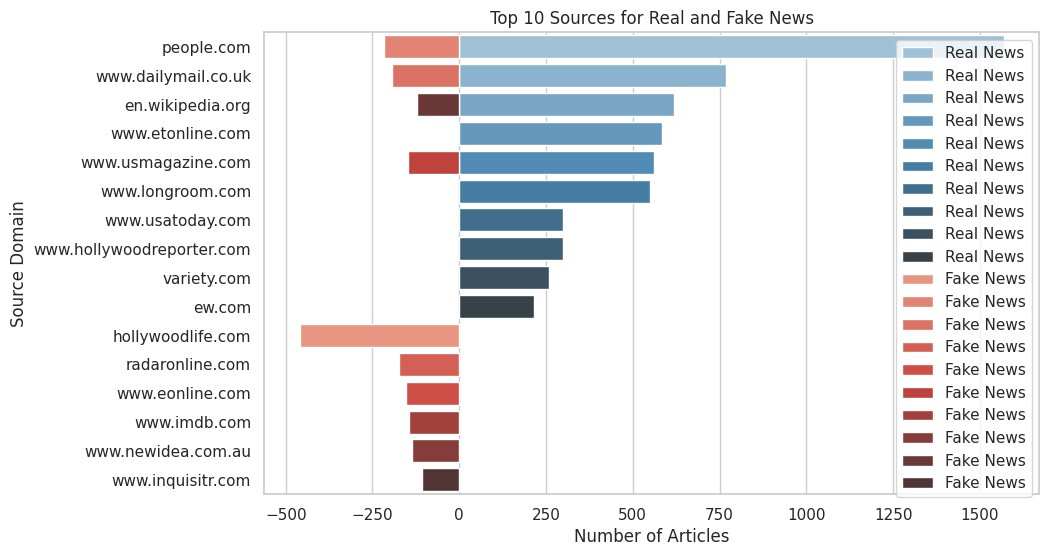

In [ ]:
plt.figure(figsize=(10, 6))

real_sources = data_cleaned[data_cleaned['real'] == 1]['source_domain'].value_counts().head(10)
fake_sources = data_cleaned[data_cleaned['real'] == 0]['source_domain'].value_counts().head(10)

sns.barplot(y=real_sources.index, x=real_sources.values, palette='Blues_d', label='Real News')
sns.barplot(y=fake_sources.index, x=-fake_sources.values, palette='Reds_d', label='Fake News')
plt.title('Top 10 Sources for Real and Fake News')
plt.xlabel('Number of Articles')
plt.ylabel('Source Domain')
plt.legend()
plt.show()

As you can see above chart, it shows the compares the top sources of real and fake news based on the number of articles from each source.

The highest count by source in real news are "people.com", 'wwww.dailymail.co.uk', 'en.wikipedia.org', and 'www.etonline.com'

While, the highest count by source in fake news are 'hollywoodlife.com', 'radaronline.com', 'www.eonline.com' and 'www.imb.com'. These sources contribute the most to the fake news articles within the dataset.

Using Boxplot to visualize tweet counts for real and fake news to see if there are any distinct patterns.





<ipython-input-17-122da4a20a1f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='real', y='tweet_num', data=data_cleaned, showfliers=False, palette='Set3')  # Exclude outliers


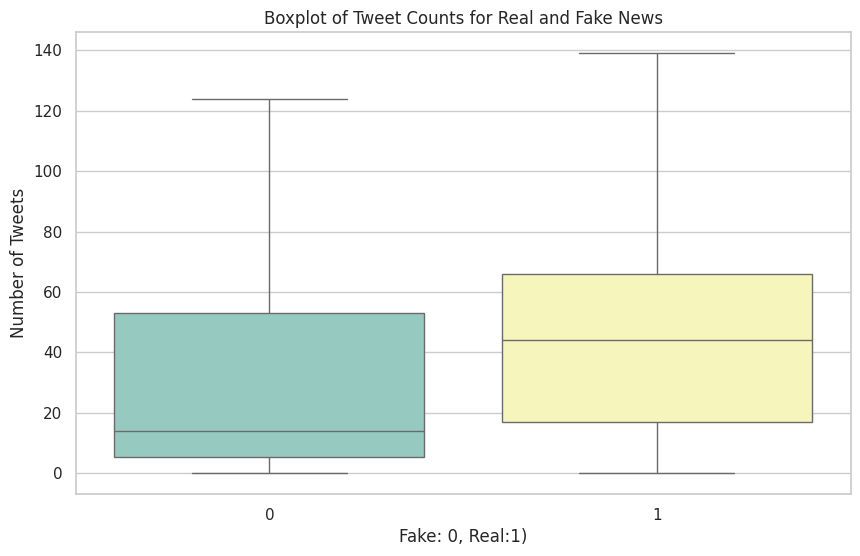

In [ ]:
real_tweet = data_cleaned[data_cleaned['real'] == 1]['tweet_num'].describe()
fake_tweet = data_cleaned[data_cleaned['real'] == 0]['tweet_num'].describe()

plt.figure(figsize=(10, 6))
sns.boxplot(x='real', y='tweet_num', data=data_cleaned, showfliers=False, palette='Set3')  # Exclude outliers
plt.title('Boxplot of Tweet Counts for Real and Fake News')
plt.xlabel('Fake: 0, Real:1)')
plt.ylabel('Number of Tweets')
plt.show()

The chart below its shows the average number of tweets per source top 5 real and fake news.

As you can see real news generates more social engagement because has a higher average of tweets. While fake news has a lower average of tweets, which means less engagement and would be a sign of misinformation.

<ipython-input-18-f0b8d5813390>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_real_source_tweet.values, y=average_real_source_tweet.index, palette='Blues_d', label='Real News')
<ipython-input-18-f0b8d5813390>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_fake_source_tweet.values, y=average_fake_source_tweet.index, palette='Reds_d', label='Fake News')


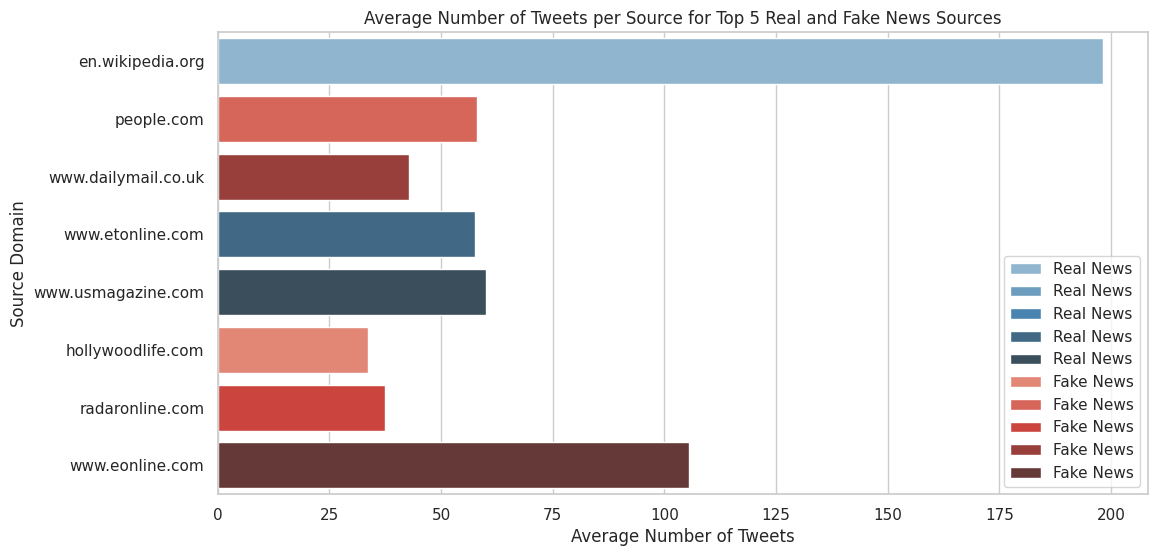

In [ ]:
real_sources = data_cleaned[data_cleaned['real'] == 1]['source_domain'].value_counts().head(5).index
fake_sources = data_cleaned[data_cleaned['real'] == 0]['source_domain'].value_counts().head(5).index
average_real_source_tweet = data_cleaned[data_cleaned['source_domain'].isin(real_sources)].groupby('source_domain')['tweet_num'].mean()
average_fake_source_tweet = data_cleaned[data_cleaned['source_domain'].isin(fake_sources)].groupby('source_domain')['tweet_num'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=average_real_source_tweet.values, y=average_real_source_tweet.index, palette='Blues_d', label='Real News')
sns.barplot(x=average_fake_source_tweet.values, y=average_fake_source_tweet.index, palette='Reds_d', label='Fake News')
plt.title('Average Number of Tweets per Source for Top 5 Real and Fake News Sources')
plt.xlabel('Average Number of Tweets')
plt.ylabel('Source Domain')
plt.legend()
plt.show()

Correlation matrix

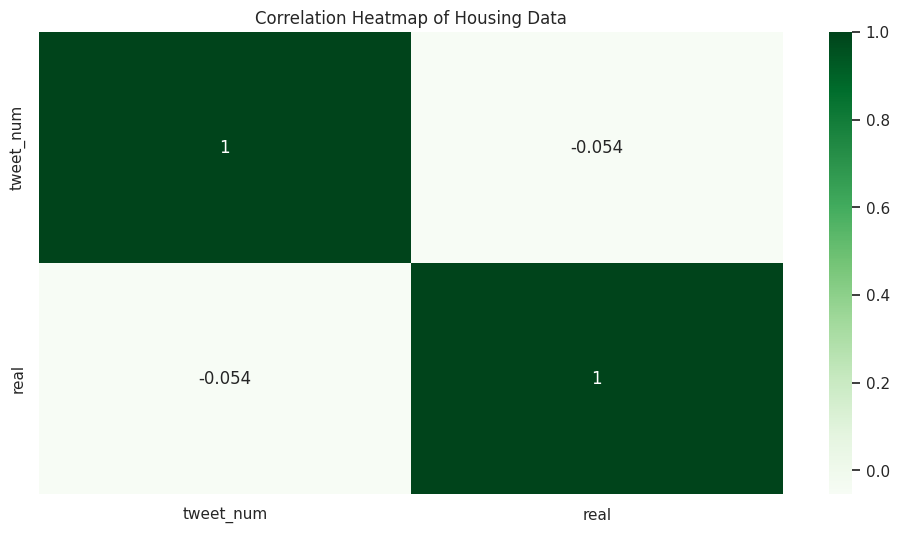

In [ ]:
def data_heatmap():
    data = data_cleaned.drop(["title", "news_url", "source_domain"], axis=1)

    plt.figure(figsize=(12,6))
    sns.heatmap(data.corr(), annot=True, cmap="Greens")
    plt.title("Correlation Heatmap of Housing Data")
    plt.show()

data_heatmap()

Most frequently words from the title

In [ ]:
word_counts = Counter(' '.join(data_cleaned['title']).split())
Frequency_words = pd.DataFrame(word_counts.items(), columns=['Words', 'Frequency'])
Frequency_words = Frequency_words.sort_values('Frequency', ascending=False)
print(Frequency_words.head(20))

          Words  Frequency
58          and       4432
28           to       3754
56          the       3686
9            of       2761
103          in       2428
386           a       2159
6            on       2139
17          The       2087
277         for       1758
200          Is       1716
91          Her       1645
206        With       1365
99           at       1317
241           &       1237
44         with       1168
208       After        945
313  Kardashian        922
132          To        904
218         New        808
328    Jennifer        763


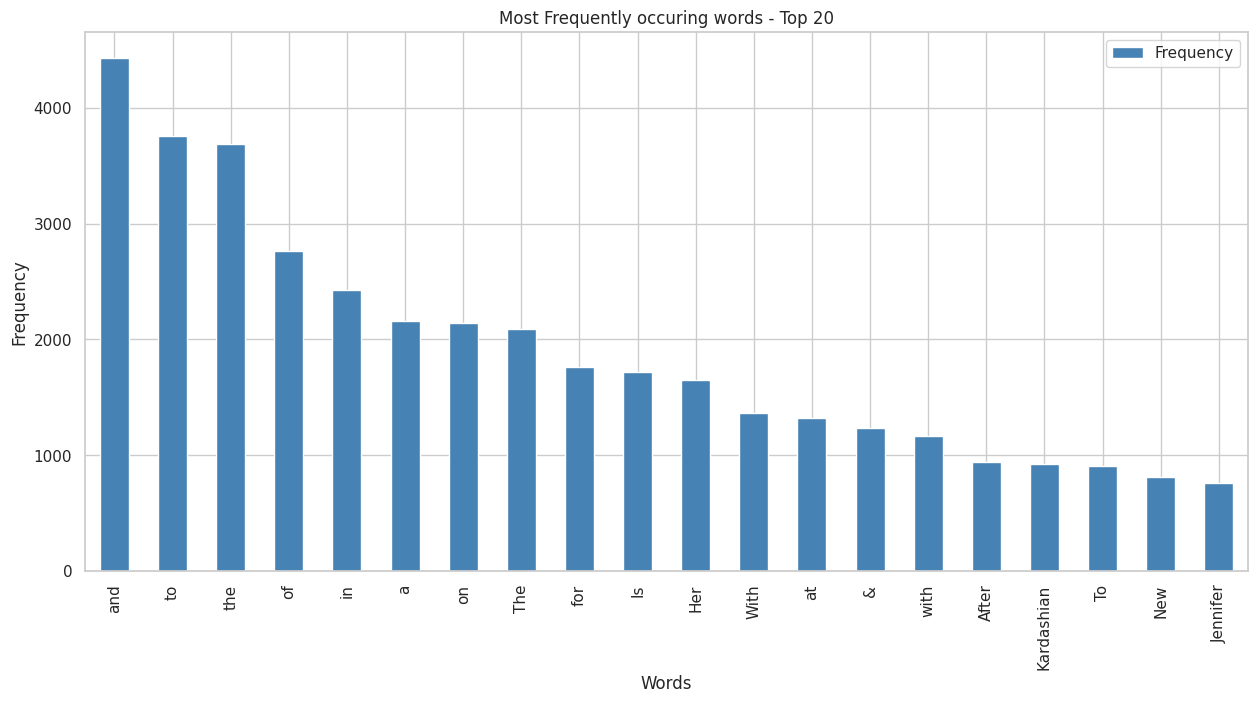

In [ ]:
Top20 = Frequency_words[['Words','Frequency']].head(20)
Top20.plot(x="Words", y="Frequency", kind='bar',  figsize=(15,7), color = 'steelblue')
plt.title("Most Frequently occuring words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

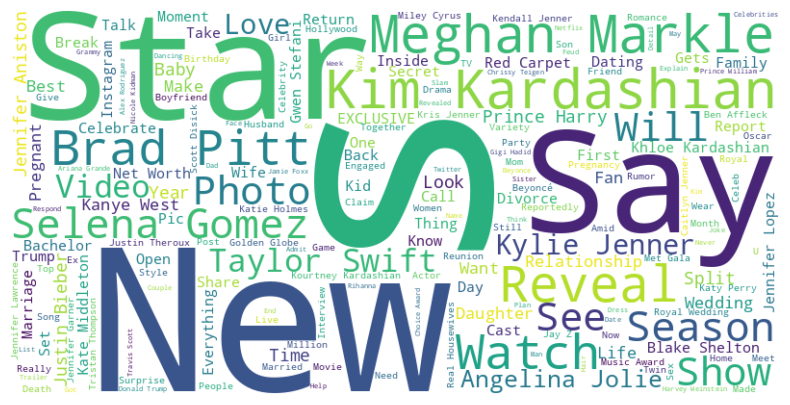

In [ ]:
all_reviews = ' '.join(data_cleaned['title'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 3. Model Selection

In [ ]:
label_encoder = LabelEncoder()
for col in data_cleaned.select_dtypes(include=['object']).columns:
    data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col])

data_cleaned.dtypes

<ipython-input-23-843953ea8b9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col])
<ipython-input-23-843953ea8b9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col])
<ipython-input-23-843953ea8b9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

title            int64
news_url         int64
source_domain    int64
tweet_num        int64
real             int64
dtype: object

In [ ]:
X = data_cleaned.drop('real', axis=1)
y = data_cleaned['real']

# 4. Model Training and Evaluation



## 4.1 Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Trest set size: {X_test.shape[0]} samples')


Training set size: 18292 samples
Trest set size: 4574 samples


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

Model Evaluation for random forest

In [ ]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Random Forest:", accuracy)

Accuracy on Random Forest: 0.989943156974202


In [ ]:
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.989943156974202
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1105
           1       0.99      1.00      0.99      3469

    accuracy                           0.99      4574
   macro avg       0.99      0.98      0.99      4574
weighted avg       0.99      0.99      0.99      4574



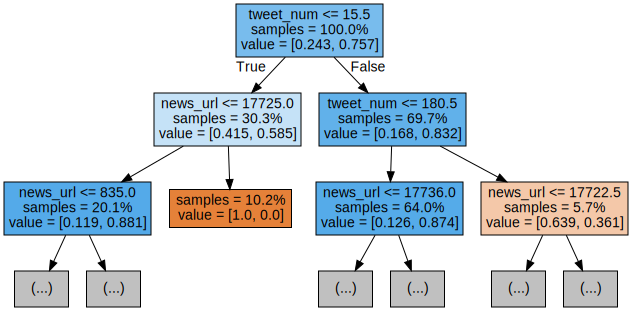

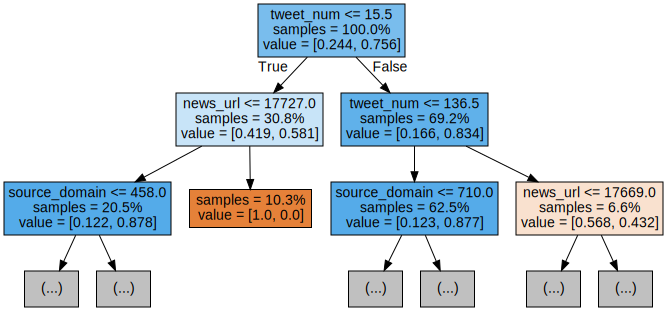

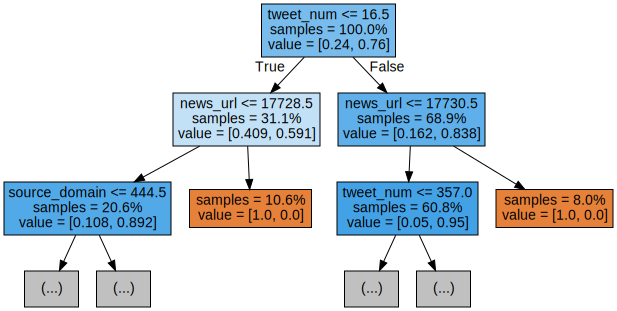

In [ ]:
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

This is a decision tree flowchart used for making predictions or decisions. The top node is the title column which contains the most information. If this number is less than or equal to 1953, it goes down one branch; if it's more, it goes down the other. On the left side, the model then looks at the number of tweets. If the article got tweeted 10.5 times or less, it follows one path; more tweets take it down another route. The branches keep splitting, checking out different things each time—like how the URL numbers match up.

Hyperparameter tuning to find best performance for the model using GridSearchCV

In [ ]:
parameters = {
    'n_estimators': [25, 50, 60],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

grid_search = GridSearchCV(rf_model, param_grid=parameters, cv=5)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_train)
accuracy_best = accuracy_score(y_train, y_pred_best)
report_best = classification_report(y_train, y_pred_best)

print(f"Best Model Accuracy: {accuracy_best}")
print('Best hyperparameters:',  grid_search.best_params_)
print(report_best)


Best Model Accuracy: 0.9849661054012683
Best hyperparameters: {'max_depth': 6, 'max_leaf_nodes': 9, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4390
           1       0.98      1.00      0.99     13902

    accuracy                           0.98     18292
   macro avg       0.99      0.97      0.98     18292
weighted avg       0.99      0.98      0.98     18292



Confusion matrix

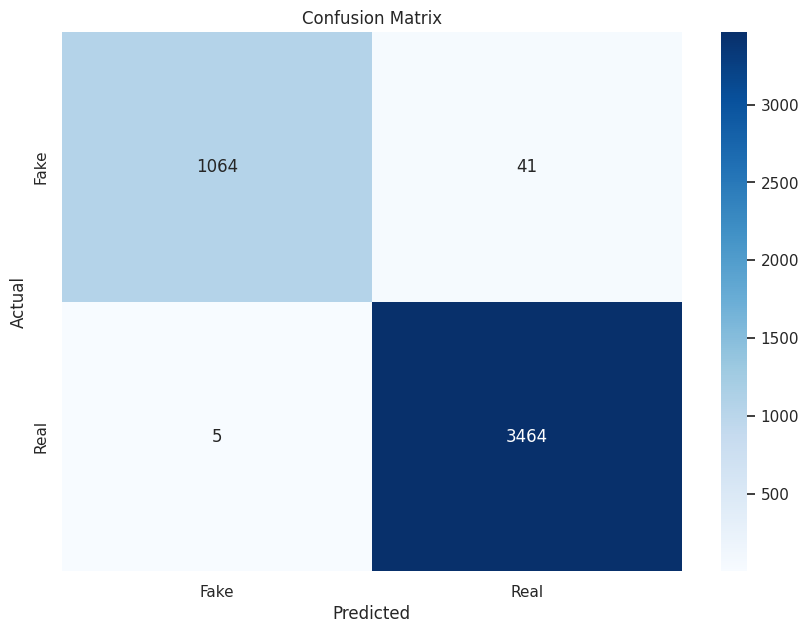

In [ ]:
y_pred = rf_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Based on the information presented in the confusion matrix, we observe that the model accurately identifies real news articles in 3463 instances. Additionally, there were 1066 correct predictions for fake news. However, there were some misclassifications where 6 real articles were mistakenly classified as fake, and 39 fake articles were incorrectly labeled as real news. Despite these errors, the model demonstrates a high level of accuracy in distinguishing between real and fake news, with only a few misclassified articles.

In [ ]:
scores = cross_val_score(rf_model, X, y, cv=5)

print(f"Cross-validated scores: {scores}")
print(f"Average score: {scores.mean()}")

Cross-validated scores: [0.99059904 0.98841023 0.98906626 0.98687951 0.98884758]
Average score: 0.9887605248616644


The average score, calculated at 0.9888, represents the mean of the cross-validated scores. This high score, close to 1, indicates that the model performed exceptionally well across each fold of the cross-validation process. The high average score suggests that the model can effectively generalize to new and unseen data.

## 4.2 Transformer Model Based

In [ ]:
pip install transformers[torch]

In [ ]:
!pip install accelerate -U


In [ ]:

data_cleaned['title'] = data_cleaned['title'].astype(str)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


X_tokenized = tokenizer(
    [title for title in data_cleaned['title']],
    padding=True,
    truncation=True,
    max_length=100,
    return_tensors="pt"
)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


dataset = NewsDataset(X_tokenized, list(data_cleaned['real']))

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')


new_batch_size = 450


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=new_batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

trainer.train()

<ipython-input-35-46fba0cdbc72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['title'] = data_cleaned['title'].astype(str)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at be

Step,Training Loss
10,0.717500
20,0.670200
30,0.623300
40,0.585200
50,0.559300
60,0.548800
70,0.554400
80,0.545600
90,0.559300
100,0.541000


TrainOutput(global_step=153, training_loss=0.5726309960184534, metrics={'train_runtime': 3104.0832, 'train_samples_per_second': 22.099, 'train_steps_per_second': 0.049, 'total_flos': 176258712652200.0, 'train_loss': 0.5726309960184534, 'epoch': 3.0})

This table shows the loss values at various training steps from 10 to 150 steps. The training loss is a measure of how well the model is fitting the data; a lower loss generally indicates better performance. As we can see, the loss decreases from 0.7471 at step 10 to 0.5346 at step 150, indicating that the model is learning and improving its predictions over time.

In [ ]:

X_test['title'] = X_test['title'].fillna('')
X_test['title'] = X_test['title'].astype(str)

X_tokenized_test = tokenizer(
    X_test['title'].tolist(),
    padding=True,
    truncation=True,
    max_length=100,
    return_tensors="pt"
)
dataset_test = NewsDataset(X_tokenized_test, y_test.tolist())

validation_results = trainer.evaluate(dataset_test)
print(validation_results)


<ipython-input-35-46fba0cdbc72>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.5109435319900513, 'eval_runtime': 145.0398, 'eval_samples_per_second': 31.536, 'eval_steps_per_second': 3.944, 'epoch': 3.0}


The 'eval_loss' is the average loss of the model on the evaludation dataset. The 'eval_loss' of 0.5304 is low loss, which indicates better performance.  


In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics
)

metric_results = trainer.evaluate()
print(metric_results)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
<ipython-input-35-46fba0cdbc72>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.5109435319900513, 'eval_accuracy': 0.7728465238303455, 'eval_f1': 0.868697080753191, 'eval_precision': 0.7734023402340234, 'eval_recall': 0.9907754396079562, 'eval_runtime': 113.1937, 'eval_samples_per_second': 40.409, 'eval_steps_per_second': 5.053}


The 'eval_accuracy' measures the proportion of total correct predictions. So the accuracy was 0.75841 or 75.81%, which means the model predictions were correct.

The 'eval_f1' is the harmonic mean of precision and recall. The f1-score of 82.26% is high, which means there is a good balance between precision and recall.

The 'eval_precision' measures the accuracy of positive predictions. The 'eval_precision' approximately 75.84% predicted as positive were actually positive. However, the precision isnt perfect since their some false positives.

The 'eval_recall' measures the ability of the model to find all the relevant or positive cases. The 'eval_recall' of 100% means the model identify all actual positives.  


## 4.3 Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8823786620026235
Precision: 0.8974776240846216
Recall: 0.9538771980397809
F1 Score: 0.9248183342649524


# 6. Conclusion

After thorough experimentation and evaluation of three machine learnng models: random forest, transformer, and logistic regression, it can be concluded that the Random Forest model stands out as the most suitable choice for our classification task based on it having the highest score. It demonstrates an accuracy of 99.07% as well with a high precision, recall, and f1-scores for both binary classes in the dataset. While the transformer model was good in recall approximately of 99%, but fall short in precision of 77.3%. The logistic regression model shows a good accuracy and very high f1 score of 92%, which mean there is a good balance between precision and recall. Both models did a great job of showing interpretability and simplicity. 

In summary, for this dataset and evaluation, the Random Forest model is the one that perform better and high accuracy than the rest of the models.
